In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
import os,sys
os.environ["CUDA_VISIBLE_DEVICES"]="7"
model_path="/data/xiaomenghan/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_path, legacy=True)
model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map="auto",
        torch_dtype=torch.float16,  # 使用半精度加速推理
        trust_remote_code=True
).eval()
# print(model)
# def activation_hook(module, input, output):
#     if isinstance(output, torch.Tensor):
#         print(f"Module: {module.__class__.__name__}, Output shape: {output.shape}")
#     elif isinstance(output, tuple):
#         for idx, out in enumerate(output):
#             if isinstance(out, torch.Tensor):
#                 print(f"Module: {module.__class__.__name__}, Output[{idx}] shape: {out.shape}")
#             else:
#                 print(f"Module: {module.__class__.__name__}, Output[{idx}] type: {type(out)}")
#     else:
#         print(f"Module: {module.__class__.__name__}, Output type: {type(output)}")

# # Register hooks to every layer of the model
# for name, module in model.named_modules():
#     module.register_forward_hook(activation_hook)

# # Prepare input text for inference
# input_text = "Hello, how are you?"
# inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

# # Perform inference
# with torch.no_grad():
#     outputs = model.generate(**inputs, max_length=50)

# # Decode the generated output
# generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print("Generated text:", generated_text)


/home/jzgrp/xiaomenghan/anaconda3/envs/quip/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/jzgrp/xiaomenghan/anaconda3/envs/quip/lib/python3.10/site-packages/accelerate/utils/modeling.py:1536: UserWarning: Current model requires 536871936 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


In [2]:
# 导入必要的库
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
import math

# 加载模型和分词器
# 注意：这里使用 "meta-llama/Llama-3.1" 作为占位符，实际使用时需替换为正确的模型名称
# 还需要确保有权限访问该模型，并可能需要登录 Hugging Face 账户
import os,sys
os.environ["CUDA_VISIBLE_DEVICES"]="1"
model_name="/data/xiaomenghan/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')  # 将模型加载到 GPU 上

# 设置 pad_token 为 eos_token，因为 Llama 模型默认可能没有定义 pad_token
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# 加载 wikitext2 数据集，选择测试集的前 128 条数据
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:128]")

# 定义分词函数，对文本进行预处理
def tokenize_function(examples):
    # truncation=True 确保序列长度不超过 max_length，padding 在后续通过 data_collator 处理
    return tokenizer(examples["text"], truncation=True, max_length=512)

# 对数据集进行分词，并移除原始文本列，只保留 input_ids 和 attention_mask
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# 设置数据集格式为 PyTorch 张量，指定需要的列
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask"])

# 定义数据整理器，用于动态填充序列到批次中最长长度
data_collator = DataCollatorWithPadding(tokenizer)

# 创建 DataLoader，设置批次大小为 8，不打乱数据顺序
dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False, collate_fn=data_collator)

# 模型评估
model.eval()  # 设置模型为评估模式，禁用 dropout 等训练相关层
total_loss = 0  # 累计总损失
total_tokens = 0  # 累计总 token 数

# 使用 torch.no_grad() 禁用梯度计算，节省内存并加速推理
with torch.no_grad():
    for batch in dataloader:
        # 将 input_ids 和 attention_mask 移动到 GPU
        input_ids = batch["input_ids"].to('cuda')
        attention_mask = batch["attention_mask"].to('cuda')
        
        # 创建 labels，与 input_ids 相同，但将 padding 位置设置为 -100 以忽略其损失
        labels = input_ids.clone()
        labels[input_ids == tokenizer.pad_token_id] = -100
        
        # 使用模型进行推理，传入 input_ids、attention_mask 和 labels
        # 模型会自动计算交叉熵损失，忽略 labels 中值为 -100 的位置
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # 获取批次的平均损失
        
        # 计算批次中非 padding token 的数量
        num_tokens = (labels != -100).sum().item()
        
        # 累计总损失：loss.item() 是平均损失，乘以 num_tokens 得到批次的总损失
        total_loss += loss.item() * num_tokens
        total_tokens += num_tokens

# 计算所有 token 的平均损失
average_loss = total_loss / total_tokens

# 计算困惑度 PPL = exp(average_loss)
perplexity = math.exp(average_loss)

# 输出结果
print(f"Perplexity: {perplexity}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Using the latest cached version of the dataset since wikitext couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'wikitext-2-raw-v1' at /home/jzgrp/xiaomenghan/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/0.0.0/b08601e04326c79dfdd32d625aee71d232d685c3 (last modified on Fri Oct 25 12:29:29 2024).
Map: 100%|██████████| 128/128 [00:00<00:00, 1222.87 examples/s]


NameError: name 'DataLoader' is not defined

In [3]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plot_tensor=model.model.layers[0]
print(plot_tensor)
tensor = plot_tensor.weight.abs().cpu().detach()

LlamaDecoderLayer(
  (self_attn): LlamaSdpaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=512, bias=False)
    (v_proj): Linear(in_features=2048, out_features=512, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (rotary_emb): LlamaDynamicNTKScalingRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm()
  (post_attention_layernorm): LlamaRMSNorm()
)


AttributeError: 'LlamaDecoderLayer' object has no attribute 'weight'

In [ ]:


# 假设你有一个形状为 [2048, 8192] 的张量

z=tensor
# 由于数据量太大，我们截取一部分进行可视化
# 例如，取前 100 行和前 100 列
step_x, step_y = 1, 1  # 增大步长可加快速度但减少细节

# 降采样后的数据
z_sampled = z[::step_x, ::step_y]

# 生成行和列索引
x_indices = np.arange(0, z.shape[0], step_x)
y_indices = np.arange(0, z.shape[1], step_y)
X, Y = np.meshgrid(x_indices, y_indices, indexing='ij')  # 确保网格与数据对齐

# 绘图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 调整rstride和cstride以加速渲染
ax.plot_surface(X, Y, z_sampled, cmap='viridis', rstride=5, cstride=5, 
                linewidth=0, antialiased=False)

ax.set_xlabel('Row (X axis)')
ax.set_ylabel('Column (Y axis)  Channel')
ax.set_zlabel('Absolute Value')
plt.title('3D Surface Plot (Downsampled)')
plt.show()

In [ ]:
sum_j_tensor=np.linalg.norm(tensor,axis=0)
print(sum_j_tensor.shape)

In [8]:
import torch
hessian=torch.load("/home/jzgrp/xiaomenghan/quip-sharp/hessians/llama32-1B/10_qkv.pt")
print(hessian)
h=hessian['flatH']
print(h.shape)


{'flatH': tensor([[ 1.2566e-01,  5.3904e-03,  6.8107e-03,  ..., -6.8963e-04,
          2.6789e-03,  3.4619e-03],
        [ 5.3904e-03,  1.5047e-01,  7.3662e-03,  ..., -4.1942e-07,
          6.6828e-03, -5.5590e-05],
        [ 6.8107e-03,  7.3662e-03,  4.1098e-01,  ..., -1.2403e-02,
         -6.3148e-03,  2.3100e-03],
        ...,
        [-6.8963e-04, -4.1942e-07, -1.2403e-02,  ...,  1.3521e-01,
          3.7708e-03, -2.1053e-03],
        [ 2.6789e-03,  6.6828e-03, -6.3148e-03,  ...,  3.7708e-03,
          1.8725e-01, -1.4360e-03],
        [ 3.4619e-03, -5.5590e-05,  2.3100e-03,  ..., -2.1053e-03,
         -1.4360e-03,  1.1517e-01]]), 'mu': tensor([-8.4864e-02, -2.4096e-02, -6.5692e-02,  ...,  2.1751e-02,
        -9.9949e-02, -4.5176e-05]), 'n': 2048, 'ct': 1048576}
torch.Size([2048, 2048])


/tmp/ipykernel_1880323/2167980173.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hessian=torch.load("/home/jzgrp/xiaomenghan/quip-sharp/hessians/llama32-1B/10_qkv.pt")


In [4]:
im=np.zeros(sum_j_tensor.shape[0])
for i in range(sum_j_tensor.shape[0]):
    im[i-1]=1/(h[i-1][i-1])


plt.figure(figsize=(10, 6))  # 设置图表的大小
plt.plot(im, linewidth=0.5, color='b')  # 绘制折线图

# 添加标题和标签
plt.title("0_v_importance", fontsize=16)
plt.xlabel("索引", fontsize=12)
plt.ylabel("数值", fontsize=12)

# 显示网格
plt.grid(True, linestyle='--', alpha=0.5)

# 显示图形
plt.show()


im.sort()
plt.figure(figsize=(10, 6))  # 设置图表的大小
plt.plot(im, linewidth=0.5, color='b')  # 绘制折线图

# 添加标题和标签
plt.title("0_down_importance", fontsize=16)
plt.xlabel("索引", fontsize=12)
plt.ylabel("数值", fontsize=12)

# 显示网格
plt.grid(True, linestyle='--', alpha=0.5)

# 显示图形
plt.show()


NameError: name 'sum_j_tensor' is not defined

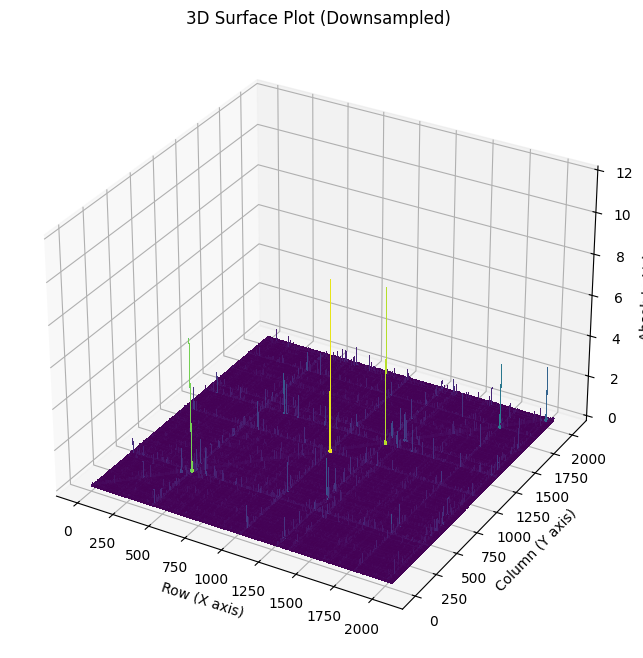

In [9]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 假设你有一个形状为 [2048, 8192] 的张量
tensor = h.abs().cpu().detach()
z=tensor
# 由于数据量太大，我们截取一部分进行可视化
# 例如，取前 100 行和前 100 列
step_x, step_y = 1, 1  # 增大步长可加快速度但减少细节

# 降采样后的数据
z_sampled = z[::step_x, ::step_y]

# 生成行和列索引
x_indices = np.arange(0, z.shape[0], step_x)
y_indices = np.arange(0, z.shape[1], step_y)
X, Y = np.meshgrid(x_indices, y_indices, indexing='ij')  # 确保网格与数据对齐

# 绘图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 调整rstride和cstride以加速渲染
ax.plot_surface(X, Y, z_sampled, cmap='viridis', rstride=5, cstride=5, 
                linewidth=0, antialiased=False)

ax.set_xlabel('Row (X axis)')
ax.set_ylabel('Column (Y axis)')
ax.set_zlabel('Absolute Value')
plt.title('3D Surface Plot (Downsampled)')
plt.show()

In [ ]:
x=torch.tensor([1,2,3,4])
x=x.t()
m1=torch.tensor([[1,2,3,4],
                 [5,6,7,8],
                 [9,10,11,12],
                 [13,14,15,16]])
m2=torch.tensor([[2,3,4,5],
                 [6,7,8,9],
                 [10,11,12,13],
                 [14,15,16,17]])
i=0
j=1
new_m1[:,[i,j]]=m1[:,[j,i]]
new_m2[:,[i,j]]=m2[:,[j,i]]
# new_order = list(range(m1.size(1)))
# new_order[i], new_order[j] = new_order[j], new_order[i]
# new_m1 = m1[new_order]
# new_order = list(range(m2.size(1)))
# new_order[i], new_order[j] = new_order[j], new_order[i]
# new_m2=m2[new_order]
print(new_m1,"\n",new_m2)


In [14]:

import torch
a=torch.tensor([[1,2,1],
                [8,8,16],
                [4,2,2]
                ]).float()
max,indices=torch.max(a,dim=0)
print(max)
b,sort=torch.sort(max)
c=torch.tensor([2,1])
print(torch.index_select(a,1,c))
print(sort)
torch.mean(a,dim=0)

tensor([ 8.,  8., 16.])
tensor([[ 1.,  2.],
        [16.,  8.],
        [ 2.,  2.]])
tensor([0, 1, 2])


tensor([4.3333, 4.0000, 6.3333])

In [ ]:


from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch
import os,sys
model_name = "VPTQ-community/Qwen2.5-7B-Instruct-v8-k65536-0-woft"  # 替换为你需要的模型名称
save_path = "/data/xiaomenghan/hub"
tokenizer = AutoTokenizer.from_pretrained(model_name, legacy=True,cache_dir=save_path)
model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        torch_dtype=torch.float16,  # 使用半精度加速推理
        trust_remote_code=True,
        cache_dir=save_path
).eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


QK^T tensor saved to qk_tensor.pt (Shape: torch.Size([1, 2048, 2048]))


/tmp/ipykernel_107419/1495503981.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  matrix=torch.load('qk_tensor.pt')


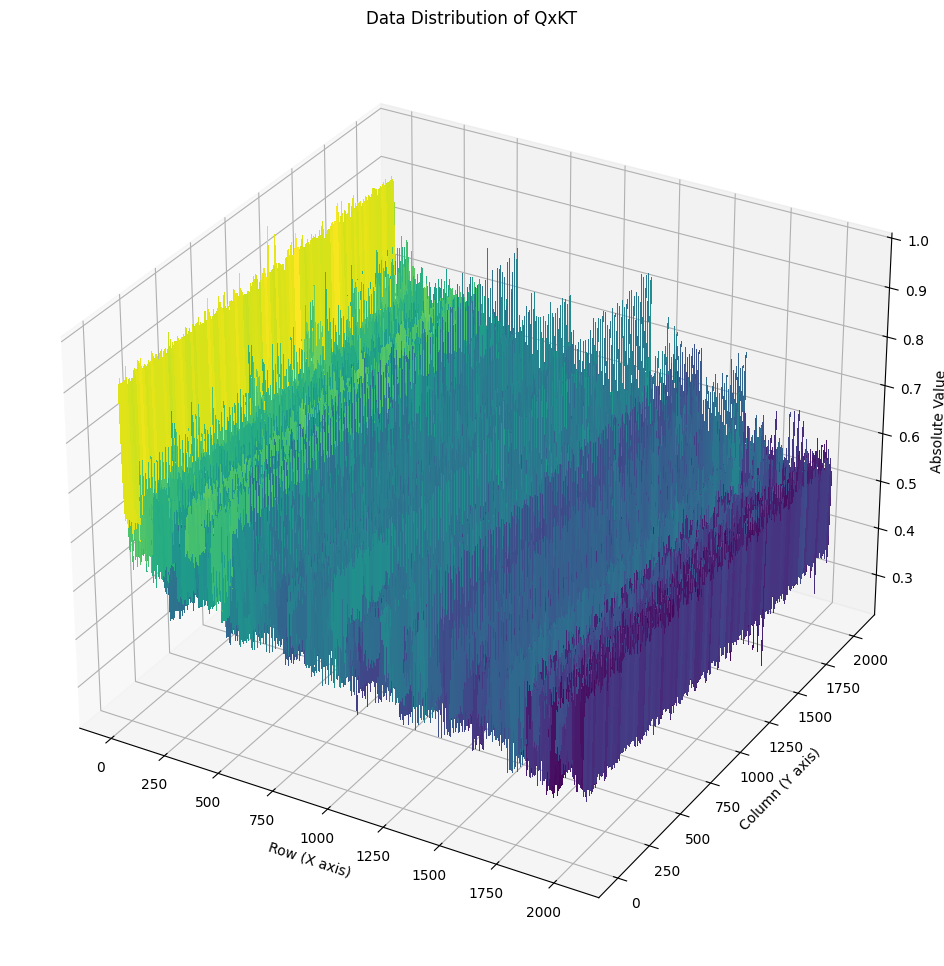

In [14]:
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
import  numpy
import  numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# 配置参数
MODEL_NAME = "/data/xiaomenghan/Llama-3.2-1B/"  # 实际使用的LLaMA模型路径
SAVE_PATH = "qk_tensor.pt"  # 保存路径
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 存储中间结果的全局变量
qk_tensor = None

def capture_qk_hook(module, input, output):
    global qk_tensor
    # output[0] 包含注意力分数 (QK^T)
    qk_tensor = output[0].detach().cpu()

# 加载模型和分词器
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = LlamaForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)

# 注册钩子到第一个Transformer层的注意力机制
first_layer = model.model.layers[2].self_attn
handle = first_layer.register_forward_hook(capture_qk_hook)

# 准备输入样本
text = "The quick brown fox jumps over the lazy dog. This is a sample sentence to demonstrate how tokens can be generated with meaningful words. In natural language processing, tokenization is the process of breaking text into individual words or tokens. These tokens can then be used for various tasks like text classification, machine translation, and sentiment analysis. The sun rises in the east and sets in the west. Water flows downstream. Birds fly in the sky. Fish swim in the ocean. The cat sat on the mat. The dog barked loudly. The baby cried for attention. The chef prepared a delicious meal. The artist painted a beautiful landscape. The musician played a soothing melody. The writer crafted an engaging story. The scientist conducted experiments to test the hypothesis. The teacher explained the concept to the students. The doctor diagnosed the patient's illness. The engineer designed the bridge with precision. The architect envisioned a modern building. The programmer wrote code to develop software. The gardener planted flowers in the spring. The farmer harvested crops in the autumn. The sailor navigated the ship through the stormy sea. The astronaut explored the mysteries of space. The detective solved the complex case. The judge presided over the court hearing. The lawyer presented evidence to support the case. The journalist reported on recent events. The photographer captured moments in time. The actor performed on stage. The singer entertained the audience. The dancer moved gracefully. The athlete ran swiftly to win the race. The student studied diligently for the exam. The employee worked hard to meet the deadline. The parent cared for the child with love. The friend offered support in times of need. The leader guided the team towards success. The follower learned from the leader's experience. The inventor created something new. The discoverer found something unknown. The pioneer blazed a trail for others to follow. The innovator brought fresh ideas to the table. The thinker contemplated deep questions. The dreamer envisioned a better future. The realist faced facts as they were. The optimist looked on the bright side. The pessimist expected the worst outcome. The neutral party remained unbiased. The enthusiast showed great excitement. The indifferent person didn't care much. The determined individual persisted despite obstacles. The hesitant one paused before acting. The brave faced fears with courage. The fearful avoided dangerous situations. The kind showed compassion to others. The unkind spoke harsh words. The generous gave freely of their resources. The selfish held onto everything tightly. The honest told the truth always. The dishonest lied for personal gain. The loyal remained faithful through tough times. The disloyal betrayed trust轻易. The wise made decisions with foresight. The foolish acted without thinking. The patient waited calmly for results. The impatient tapped their foot in annoyance. The clean kept everything tidy. The messy left things in disarray. The loud drew attention with volume. The quiet spoke softly but clearly. The fast completed tasks迅速ly. The slow took their time carefully. The strong lifted heavy weights with ease. The weak struggled to carry the load. The tall reached high places without effort. The short used a stool to compensate. The young had boundless energy. The old possessed wisdom from experience. The healthy enjoyed vibrant vitality. The sick longed for recovery soon. The rich had more than enough. The poor scraped by with little. The famous were recognized everywhere. The unknown remained obscure. The happy smiled broadly each day. The sad wore a frown constantly. The excited couldn't contain their enthusiasm. The bored yawned repeatedly. The surprised jumped at sudden news. The calm remained unruffled by events. The angry lashed out in frustration. The peaceful promoted harmony among people. The guilty felt remorse for actions. The innocent had nothing to hide. The brave faced challenges head-on. The cowardly shrank from difficulty. The clever found creative solutions. The dull missed the point entirely. The polite said please and thank you. The rude offended without intention. The fashionable wore the latest trends. The outdated clung to old styles. The neat arranged things orderly. The sloppy let everything become messy. The energetic filled the room with vitality. The lethargic moved in slow motion. The confident walked with head held high. The insecure slouched to hide. The friendly offered a warm handshake. The hostile glared with suspicion. The helpful assisted without being asked. The unhelpful stood by idly. The responsible took care of duties. The irresponsible forgot commitments. The careful avoided mistakes through attention. The careless made errors constantly. The methodical followed a clear plan. The haphazard approached tasks randomly. The persistent kept going despite setbacks. The quitter gave up at the first hurdle. The ambitious aimed for great achievements. The contented were happy with what they had. The curious asked many questions daily. The indifferent didn't care to know more. The creative thought outside the box. The conventional followed traditional paths. The flexible adapted to change easily. The rigid resisted any alteration. The generous shared with those in need. The stingy counted every penny spent. The truthful valued honesty above all. The deceptive used tricks to manipulate. The loyal stood by friends through thick and thin. The disloyal switched sides for advantage. The kind performed acts of service gladly. The unkind spoke harshly without thought. The patient waited their turn quietly. The impatient tapped feet and sighed. The clean maintained spotless environments. The messy tolerated clutter everywhere. The loud announced their presence everywhere. The quiet made their point without shouting. The fast finished quickly but sometimes carelessly. The slow produced careful work but took time. The strong helped others with heavy lifting. The weak asked for assistance when needed. The tall reached high shelves with ease. The short used a step stool when necessary. The young adapted quickly to new technologies. The old relied on experience and wisdom. The healthy enjoyed life's adventures fully. The sick hoped for swift recovery. The rich donated to worthy causes. The poor struggled to make ends meet. The famous signed autographs for fans. The unknown worked hard for recognition. The happy shared joy with everyone. The sad withdrew from social contact. The excited talked rapidly about news. The bored stared blankly at nothing. The surprised gasped at unexpected events. The calm remained centered in chaos. The angry shouted and slammed doors. The peaceful mediated conflicts gently. The guilty avoided eye contact. The innocent asked why the accusation. The brave charged into battle. The cowardly hid behind others. The clever solved puzzles quickly. The dull stared confused at problems. The polite opened doors for others. The rude pushed to the front. The fashionable set new trends. The outdated followed last year's. The neat organized everything. The sloppy let disorder reign. The energetic danced all night. The lethargic could barely stay awake. The confident gave inspiring speeches. The insecure mumbled and looked down. The friendly organized gatherings. The hostile created divisions. The helpful built shelves. The unhelpful watched from sidelines. The responsible paid bills on time. The irresponsible forgot deadlines. The careful proofread documents. The careless missed obvious errors. The methodical planned each step. The haphazard jumped in without thought. The persistent kept applying despite rejections. The quitter decided it wasn't worth it. The ambitious climbed the corporate ladder. The contented enjoyed their current position. The curious explored new territories. The indifferent remained in comfort zone. The creative painted masterpieces. The conventional copied traditional styles. The flexible learned new methods. The rigid stuck to old ways. The generous donated time and money. The stingy kept resources to self. The truthful maintained integrity. The deceptive lied to get ahead. The loyal supported through ups and downs. The disloyal changed sides for benefit. The kind volunteered at shelters. The unkind made cruel remarks. The patient waited for growth. The impatient demanded immediate results. The clean maintained hygiene. The messy lived in disorder. The loud announced presence. The quiet influenced subtly. The fast completed tasks. The slow ensured quality. The strong protected the weak. The weak found inner strength. The tall reached for stars. The short stood on shoulders. The young dreamed big dreams. The old shared wisdom gained. The healthy embraced active life. The sick hoped for healing. The rich shared abundance. The poor sought opportunities. The famous inspired fans. The unknown worked diligently. The happy spread joy. The sad found comfort. The excited embraced new adventures. The bored sought stimulation. The surprised found wonder. The calm provided peace. The angry found resolution. The peaceful created harmony. The guilty found forgiveness. The innocent proved truth. The brave faced fears. The cowardly found courage. The clever innovated solutions. The dull discovered interest. The polite showed respect. The rude learned manners. The fashionable influenced trends. The outdated embraced new styles. The neat organized chaos. The sloppy found order. The energetic motivated others. The lethargic found energy. The confident inspired belief. The insecure gained confidence. The friendly built connections. The hostile found understanding. The helpful created community. The unhelpful learned contribution. The responsible set example. The irresponsible faced consequences. The careful avoided pitfalls. The careless learned lessons. The methodical achieved goals. The haphazard found path. The persistent reached success. The quitter reconsidered choice. The ambitious achieved greatness. The contented found happiness. The curious discovered knowledge. The indifferent sparked interest. The creative transformed vision. The conventional evolved traditions. The flexible adapted change. The rigid bent without breaking. The generous received blessings. The stingy experienced scarcity. The truthful lived freely. The deceptive faced exposure. The loyal gained trust. The disloyal faced isolation. The kind received kindness. The unkind faced karma. The patient achieved results. The impatient missed process. The clean found peace. The messy discovered order. The loud communicated clearly. The quiet spoke volumes. The fast finished race. The slow enjoyed journey. The strong lifted others. The weak became strong. The tall stood proud. The short saw far. The young inspired change. The old guided wisdom. The healthy promoted wellness. The sick recovered strength. The rich shared wealth. The poor created richness. The famous became humble. The unknown became known. The happy inspired joy. The sad found light. The excited embraced life. The bored discovered passion. The surprised found magic. The calm created storm. The angry found peace. The peaceful ignited revolution. The guilty found redemption. The innocent proved innocence. The brave inspired courage. The cowardly found bravery. The clever invented future. The dull experienced brilliance. The polite revolutionized manners. The rude redefined respect. The fashionable created movement. The outdated revolutionized style. The neat organized world. The sloppy discovered system. The energetic changed universe. The lethargic found momentum. The confident led nations. The insecure gained power. The friendly connected worlds. The hostile found peace. The helpful transformed society. The unhelpful became useful. The responsible changed climate. The irresponsible faced reality. The careful prevented disaster. The careless caused accident. The methodical built empire. The haphazard found method. The persistent achieved impossible. The quitter found persistence. The ambitious changed world. The contented found ambition. The curious discovered universe. The indifferent found curiosity. The creative invented future. The conventional revolutionized tradition. The flexible adapted world. The rigid broke barriers. The generous received universe. The stingy experienced generosity. The truthful lived legend. The deceptive faced truth. The loyal gained world. The disloyal found loyalty. The kind received universe. The unkind faced kindness. The patient achieved dream. The impatient found patience. The clean changed world. The messy discovered order. The loud spoke softly. The quiet roared loudly. The fast walked slowly. The slow ran quickly. The strong became weak. The weak became strong. The tall became short. The short became tall. The young became old. The old became young. The healthy became sick. The sick became healthy. The rich became poor. The poor became rich. The famous became unknown. The unknown became famous. The happy became sad. The sad became happy. The excited became bored. The bored became excited. The surprised became calm. The calm became surprised. The angry became peaceful. The peaceful became angry. The guilty became innocent. The innocent became guilty. The brave became cowardly. The cowardly became brave. The clever became dull. The dull became clever. The polite became rude. The rude became polite. The fashionable became outdated. The outdated became fashionable. The neat became messy. The messy became neat. The energetic became lethargic. The lethargic became energetic. The confident became insecure. The insecure became confident. The friendly became hostile. The hostile became friendly. The helpful became unhelpful. The unhelpful became helpful. The responsible became irresponsible. The irresponsible became responsible. The careful became careless. The careless became careful. The methodical became haphazard. The haphazard became methodical. The persistent became quitter. The quitter became persistent. The ambitious became contented. The contented became ambitious. The curious became indifferent. The indifferent became curious. The creative became conventional. The conventional became creative. The flexible became rigid. The rigid became flexible. The generous became stingy. The stingy became generous. The truthful became deceptive. The deceptive became truthful. The loyal became disloyal. The disloyal became loyal. The kind became unkind. The unkind became kind. The patient became impatient. The impatient became patient. The clean became messy. The messy became clean. The loud became quiet. The quiet became loud. The fast became slow. The slow became fast. The strong became weak. The weak became strong. The tall became short. The short became tall. The young became old. The old became young. The healthy became sick. The sick became healthy. The rich became poor. The poor became rich. The famous became unknown. The unknown became famous. The happy became sad. The sad"
inputs = tokenizer(text, return_tensors="pt",max_length=2048).to(DEVICE)

# 运行模型并捕获数据
with torch.no_grad():
    outputs = model(**inputs)

# 移除钩子
handle.remove()

# 保存结果
if qk_tensor is not None:
    torch.save(qk_tensor, SAVE_PATH)
    print(f"QK^T tensor saved to {SAVE_PATH} (Shape: {qk_tensor.shape})")
else:
    print("Failed to capture QK^T tensor")

# 释放显存
del model
torch.cuda.empty_cache()
matrix=torch.load('qk_tensor.pt')
matrix=matrix.squeeze(0)
row_max, _ = torch.max(matrix, dim=1, keepdim=True)

# 每行的每个元素减去对应的最大值
result = matrix - row_max
matrix=result.abs()
# matrix = torch.exp(result)
# z = matrix
z=matrix.cpu().detach().numpy()
# z=np.abs(z)
# 由于数据量太大，我们截取一部分进行可视化
# 例如，取前 100 行和前 100 列
step_x, step_y = 4, 4  # 增大步长可加快速度但减少细节

# 降采样后的数据
z_sampled = z[::step_x, ::step_y]

# 生成行和列索引
x_indices = np.arange(0, z.shape[0], step_x)
y_indices = np.arange(0, z.shape[1], step_y)
X, Y = np.meshgrid(x_indices, y_indices, indexing='ij')  # 确保网格与数据对齐

# 绘图
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# 调整rstride和cstride以加速渲染
ax.plot_surface(X, Y, z_sampled, cmap='viridis', rstride=5, cstride=5, 
                linewidth=0, antialiased=False)


ax.set_xlabel('Row (X axis)')
ax.set_ylabel('Column (Y axis)')
ax.set_zlabel('Absolute Value')
plt.title('Data Distribution of QxKT')
plt.savefig('3d_bar_chart.png', dpi=400, bbox_inches='tight')

